In [1]:
import numpy as np
import csv
import os
import keras
import sys
import cv2
import pickle
from os.path import dirname
from os import getcwd
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from framework.util import get_gender_label, get_image_array, myStandardScaler, Generate_feature, MaxPooling

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [2]:
def flip_aug(x):
    new_x = []
    for i in range(len(x)):
        new_x.append(cv2.flip(x[i], 1).reshape(x.shape[1], x.shape[2], -1))
    return np.array(new_x)

def cwPCA(x, eng_percent):
    pca = PCA(n_components=500)
    x = pca.fit_transform(x)
    ratio = np.cumsum(pca.explained_variance_ratio_) >= eng_percent
    n_comp = np.argmax(ratio)
    #print(n_comp, " compontents retained!")
    x = x[:, :n_comp]
    dis = euclidean_distances(x, x)+1000*np.eye(len(x))
    return dis

def pca_aug(x, eng_percent=0.9):
    xx = x.copy()
    x = x.reshape(x.shape[0], -1, 1)/255
    dis0 = cwPCA(x[:,:,0], eng_percent)
    idx = np.argmin(dis0, axis=1)
    new_x = []
    ct = 0
    for i in range(len(xx)):
        tmp = xx[i]/2 + xx[idx[i]] / 2
        #tmp = cv2.equalizeHist(tmp.astype(np.uint8))
        new_x.append(tmp)
        if ct > 0:
            plt.imshow(tmp[:,:])
            plt.title('mean')
            plt.show()
            plt.imshow(xx[i,:,0])
            plt.title('raw')
            plt.show()
            ct -= 1
    return np.array(new_x).reshape(xx.shape[0], xx.shape[1], xx.shape[2], -1)

def data_aug(xf):
    x1 = flip_aug(xf)
    print(x1.shape)
    x2 = pca_aug(xf)
    print(x2.shape)
    xf = np.concatenate((xf, x1, x2), axis=0)
    print('after aug', xf.shape)
    return xf

In [3]:
from glob import glob
import os
import cv2  

datasetPath= "/Users/alex/Desktop/proj/face_gender/data/HEMPIE2/SavedHEMPIE2/"  
file1 = open('/Users/alex/Desktop/proj/face_gender/data/HEMPIE2/subject_list.txt', 'r') 
Lines = file1.readlines() 
  
dictionary={}
for line in Lines:
    #print(line)
    try:
        identity_num=line.split(' ')[0]
        gender=line.split(' ')[2]
        dictionary[identity_num]= 0 if gender=='Male' else 1
    except:
        continue

data=[]
labels=[]
identities=glob(datasetPath+"*")
for identity in identities:
    g = os.path.basename(identity).split('.')[0].split('-')[0]
    #print(g)
    if g != '1':
        continue
    identityId = os.path.basename(identity).split('.')[0].split('-')[1]
    while len(identityId)<3:
        identityId='0'+identityId
    try:
        img = cv2.resize(cv2.imread(identity)[:,:,0],(32,32))
    except:
        continue
    data.append(img)
    labels.append(dictionary[identityId])
data = np.array(data).reshape(-1, 32, 32, 1)
labels = np.array(labels)
print(len(data), len(labels))

29860 29860


In [6]:
print(data.shape, labels.shape)
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels)
#train_images, test_images, y, yt = train_test_split(train_images, y, test_size=0.2, stratify=y)


#x_aug = data_aug(train_images[y==1])
#train_data = np.concatenate((train_data, x_aug), axis=0)
#train_labels = np.concatenate((y, np.ones(len(x_aug))), axis=0)
print(train_data.shape)
train_data = train_data.astype('float32')  
test_data = test_data.astype('float32') 
train_data /= 255.  
test_data /= 255.
train_labels = np_utils.to_categorical(train_labels, 2)
test_labels = np_utils.to_categorical(test_labels, 2)

(29860, 32, 32, 1) (29860,)
(23888, 32, 32, 1)


In [7]:
def LeNet5():
    model = Sequential()
    model.add(Convolution2D(filters = 6, kernel_size = (5, 5), padding = "valid", input_shape = (32, 32, 1)))
    model.add(Activation(activation = "relu"))
    model.add(MaxPooling2D(pool_size = (2, 2), strides =  (2, 2)))
    model.add(Convolution2D(filters = 16, kernel_size = (5, 5), padding = "valid"))
    model.add(Activation(activation = "relu"))
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    model.add(Convolution2D(filters = 120, kernel_size = (5, 5), padding = "valid"))
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation(activation = "relu"))
    model.add(Dense(84))
    model.add(Activation(activation = "relu"))
    model.add(Dense(2))
    model.add(Activation("softmax"))
    model.compile(loss = "categorical_crossentropy", optimizer = keras.optimizers.RMSprop(), metrics = ["accuracy"])
    return model
model = LeNet5()
model.summary()





Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
keep_dims is deprecated, use keepdims instead

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 10, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0

In [9]:
a, at = [], []
hist = []
nb_epoch = 20
for i in range(4):
    print('------',i)
    model = LeNet5()
    history = model.fit(train_data, train_labels, batch_size = 128, epochs = nb_epoch, verbose = 1, validation_data=(test_data, test_labels),shuffle=True)
    a.append(history.history['acc'])
    at.append(history.history['val_acc'])
    hist.append(history)
    

------ 0
Train on 23888 samples, validate on 5972 samples
Epoch 1/20
23888/23888 [==============================] - 10s 407us/step - loss: 0.5283 - acc: 0.7444 - val_loss: 0.3784 - val_acc: 0.8521
Epoch 2/20
23888/23888 [==============================] - 9s 394us/step - loss: 0.3249 - acc: 0.8635 - val_loss: 0.2549 - val_acc: 0.8932
Epoch 3/20
23888/23888 [==============================] - 9s 392us/step - loss: 0.2521 - acc: 0.8959 - val_loss: 0.3710 - val_acc: 0.8327
Epoch 4/20
23888/23888 [==============================] - 9s 397us/step - loss: 0.2048 - acc: 0.9177 - val_loss: 0.2654 - val_acc: 0.8972
Epoch 5/20
23888/23888 [==============================] - 10s 406us/step - loss: 0.1670 - acc: 0.9305 - val_loss: 0.1508 - val_acc: 0.9406
Epoch 6/20
23888/23888 [==============================] - 10s 406us/step - loss: 0.1391 - acc: 0.9455 - val_loss: 0.1499 - val_acc: 0.9389
Epoch 7/20
23888/23888 [==============================] - 10s 412us/step - loss: 0.1163 - acc: 0.9556 - val_los

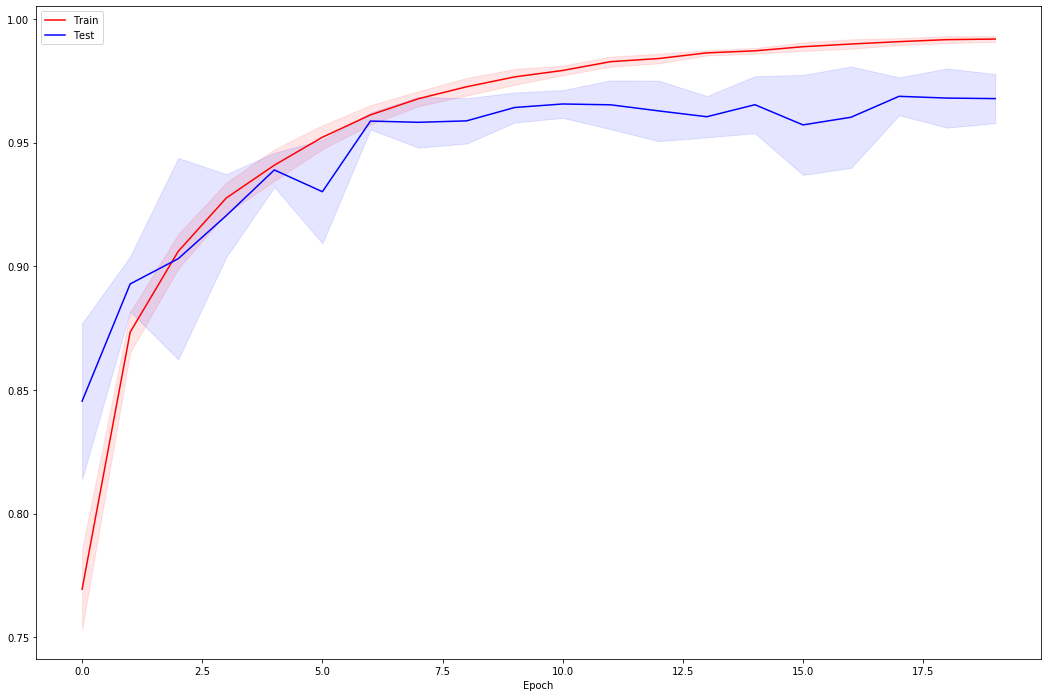

In [10]:
plt.figure(figsize=(18, 12))
plt.plot(np.arange(nb_epoch), np.mean(a, axis=0), color='r')
plt.fill_between(np.arange(nb_epoch), np.mean(a, axis=0)+np.std(a, axis=0), np.mean(a, axis=0)-np.std(a, axis=0), color='r', alpha=0.1)
plt.plot(np.arange(nb_epoch), np.mean(at, axis=0), color='b')
plt.fill_between(np.arange(nb_epoch), np.mean(at, axis=0)+np.std(at, axis=0), np.mean(at, axis=0)-np.std(at, axis=0), color='b', alpha=0.1)
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
(loss, accuracy) = model.evaluate(test_data, test_labels, batch_size = 128, verbose = 0)
print('loss:', loss, '\nval acc:', accuracy)

loss: 0.16631433487497396 
val acc: 0.9507702608197948


In [12]:
a = np.mean(a, axis=0)
at = np.mean(at, axis=0)
print(a[-1], at[-1])

0.9918369055592766 0.9677662422252995


In [ ]:
$